In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb

warnings.filterwarnings('ignore')
%matplotlib inline

## Lendo dados

In [2]:
dados = pd.read_csv('/kaggle/input/data-train-secitec-ifg/treino.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11389 entries, 0 to 11388
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11389 non-null  int64  
 1   idademae        11389 non-null  float64
 2   estadocivilmae  11293 non-null  object 
 3   catprenatal     11349 non-null  object 
 4   qtdsemanas      11163 non-null  float64
 5   tipoparto       11384 non-null  object 
 6   peso            11387 non-null  float64
 7   malformacao     11085 non-null  object 
 8   sexo            11350 non-null  object 
 9   apgar1          11289 non-null  float64
 10  apgar5          11294 non-null  float64
 11  obito           11389 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 1.0+ MB


In [3]:
teste = pd.read_csv('/kaggle/input/data-train-secitec-ifg/teste.csv')
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882 entries, 0 to 4881
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4882 non-null   int64  
 1   idademae        4881 non-null   float64
 2   estadocivilmae  4844 non-null   object 
 3   catprenatal     4869 non-null   object 
 4   qtdsemanas      4786 non-null   float64
 5   tipoparto       4882 non-null   object 
 6   peso            4882 non-null   float64
 7   malformacao     4739 non-null   object 
 8   sexo            4870 non-null   object 
 9   apgar1          4834 non-null   float64
 10  apgar5          4833 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 419.7+ KB


In [4]:
submissao = pd.read_csv('/kaggle/input/data-train-secitec-ifg/submission.csv')
submissao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882 entries, 0 to 4881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      4882 non-null   int64  
 1   obito   4882 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 76.4 KB


Temos datasets pequenos (o dataset de treino tem somente 1 MB), comparados com alguns aqui do Kaggle.

## Análise exploratória de dados

In [5]:
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0


**Dicionário de dados:**
       
- idademae: Idade da mãe em anos    
- estadocivilmae: Estado Civil da Mãe    
- catprenatal: Quantidade de Consultas pré-natal realizadas pela mãe    
- qtdsemanas: Idade gestacional no momento do parto em semanas    
- tipoparto: Tipo do parto    
- peso: Peso do recém-nascido no momento do nascimento em gramas    
- malformacao: Se foi observada alguma mal formação no bebê    
- sexo: Sexo do recém-nascio (f=feminino, m=masculino)    
- apgar1: Apgar no 1º Minuto    
- apgar5: Apgar no 5º Minuto    
- obito: Indica se o recém-nascido veio a óbito antes de completar 1 ano de vida    

### O que é Apgar?   
       
A Escala ou Índice de Apgar é um teste desenvolvido pela Dra. Virginia Apgar (1909 – 1974), médica norte-americana, que consiste na avaliação por um pediatra de 5 sinais objetivos do recém-nascido, atribuindo-se a cada um dos sinais uma pontuação de 0 a 2. O teste, aplicado duas vezes (no primeiro e no quinto minuto após o nascimento), é utilizado para avaliar o ajuste imediato do recém-nascido à vida extrauterina, sendo que os sinais avaliados são: frequência cardíaca, respiração, tônus muscular, irritabilidade reflexa e cor da pele. O somatório da pontuação (no mínimo 0 e no máximo 10) resultará no Índice de Apgar e o recém-nascido será classificado como:

- sem asfixia (Apgar 8 a 10);    
- com asfixia leve (Apgar 5 a 7);    
- com asfixia moderada (Apgar 3 a 4) ou    
- com asfixia grave: Apgar 0 a 2.    
    
****
    
**APGAR**:    
- **A**parência
     
- **P**ulso   
    
- **G**esticulação
    
- **A**tividade
    
- **R**espiração
      
*Fonte: https://pt.wikipedia.org/wiki/Escala_de_Apgar*

In [6]:
dados['apgar1'].value_counts(dropna=False).sort_index()

0.0       97
1.0      416
2.0      349
3.0      334
4.0      311
5.0      318
6.0      483
7.0      861
8.0     2750
9.0     4865
10.0     505
NaN      100
Name: apgar1, dtype: int64

In [7]:
dados['apgar5'].value_counts(dropna=False).sort_index()

0.0      125
1.0      190
2.0      119
3.0      134
4.0      174
5.0      208
6.0      296
7.0      480
8.0      918
9.0     3100
10.0    5550
NaN       95
Name: apgar5, dtype: int64

Podemos ver que temos crianças com `asfixia grave` (Apgar 0 a 2), por exemplo.   
Temos alguns valores `NaN` também.

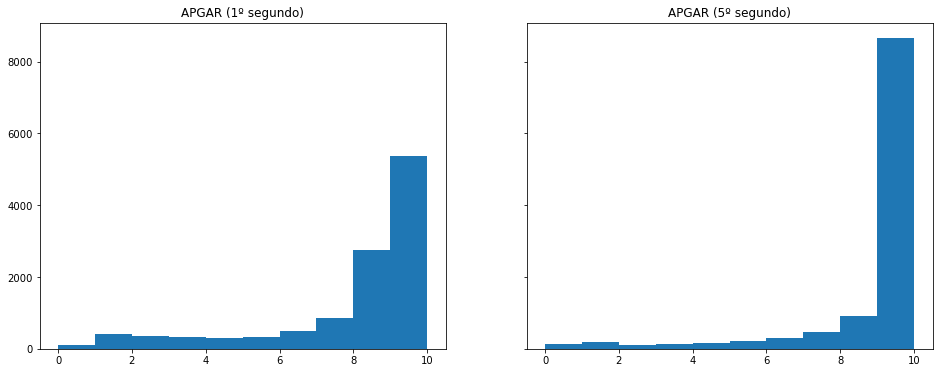

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for name, ax in zip(['apgar1', 'apgar5'], axes):
    ax.hist(dados[name])
    ax.set_title(f'APGAR ({name[-1]}º segundo)')

fig.show();

## Visualizando frequências das *features* categóricas

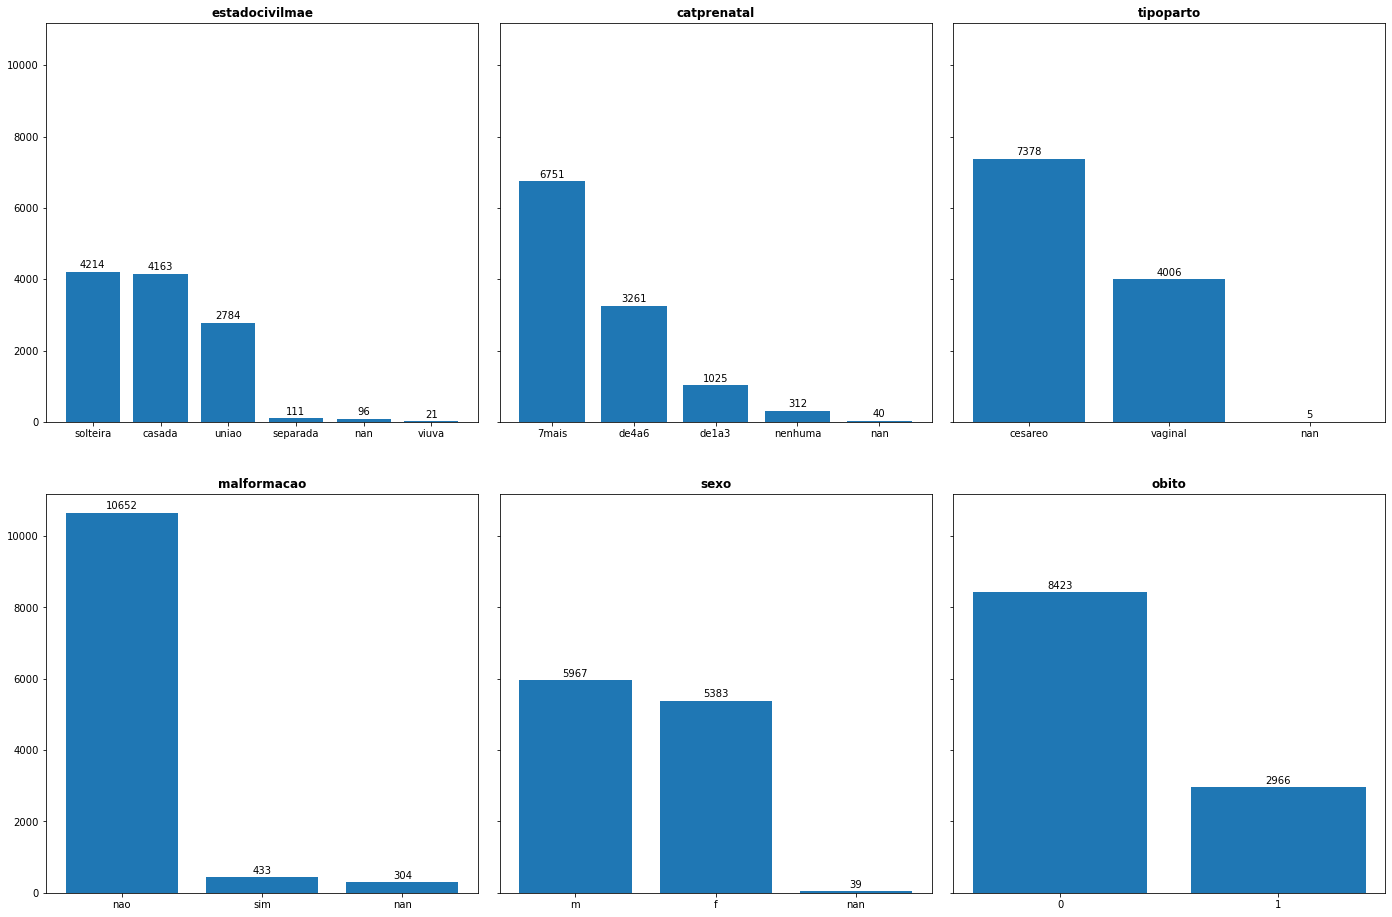

In [9]:
cat_features = ['estadocivilmae', 'catprenatal', 'tipoparto', 'malformacao', 'sexo', 'obito']

fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharey=True, gridspec_kw={'wspace': .05, 'hspace': .18})

axes = axes.ravel()

for name, ax in zip(cat_features, axes):
    
    counts = dados[name].value_counts(dropna=False)
    ax.bar(counts.index.astype(str), counts)
    ax.set_title(name, fontname='Times New Roman', fontweight='bold')
    ax.set_axisbelow(True)
    
    for x, y in enumerate(counts):
        ax.text(x=x, y=y+100, s=str(y), horizontalalignment='center')

fig.show();

Todas as *features* categóricas possuem `NaN` (apesar de serem poucos valores). 
    
### Outra coisa importante é que nossa *target* está bem desbalanceada (há muito mais sobrevivências do que óbitos).

## Visualizando *features* numéricas

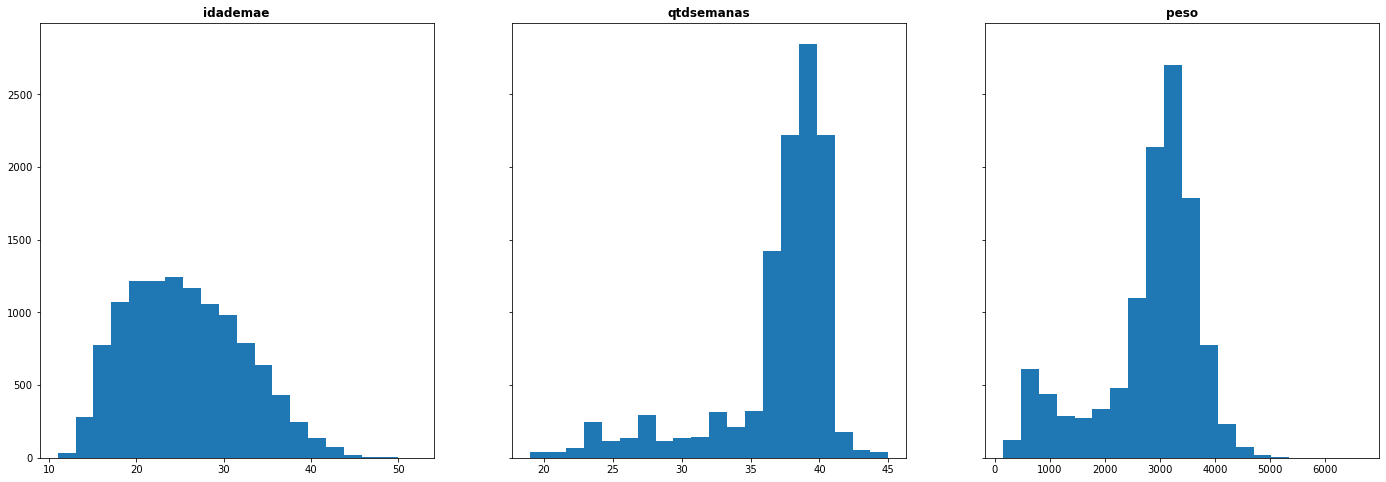

In [10]:
num_features = ['idademae', 'qtdsemanas', 'peso']

fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

for name, ax in zip(num_features, axes):
    ax.hist(dados[name], bins=20)
    ax.set_title(name, fontname='Times New Roman', fontweight='bold')

fig.show();

A *feature* `idademae` é assimétrica à esquerda, enquanto `qtdsemanas` é assimétrica à direta. Já `peso` parece ter duas modas.    

In [11]:
# temos NaN?
dados[num_features].isna().sum()

idademae        0
qtdsemanas    226
peso            2
dtype: int64

In [12]:
pd.DataFrame(dados[num_features].describe()).T

,count,mean,std,min,25%,50%,75%,max
idademae,11389.0,25.793748,6.468443,11.0,21.0,25.0,30.0,52.0
qtdsemanas,11163.0,36.952611,4.421121,19.0,37.0,38.0,39.0,45.0
peso,11387.0,2818.527883,930.575296,150.0,2550.0,3060.0,3412.0,6651.0


## Transformando variáveis categóricas
   
Antes de fazer o *split* em treino/validação, podemos transformar as variáveis categóricas para os dados completos, porque uma `categoria=0` dos dados de treino
precisa ser a mesma categoria nos dados de validação, senão estaríamos "bagunçando" toda a lógica dos dados.   
    
Mas precisamos tomar cuidado: algumas variáveis só podem ser transformadas depois do *split*. Por exemplo, se transformarmos a variável `idademae` para
os dados completos, estaríamos "interferindo" na distribuição desta variável nos dados de validação. Isso é um problema, porque teoricamente os dados de 
validação precisam ser totalmente desconhecidos pelo modelo. Se categorizarmos usando os dados completos, então informações dos dados de validação serão usados
para treinar o modelo, podendo causar uma boa performance em dados de treino e/ou validação, porém má performance em dados desconhecidos. Esse é um exemplo de *data leakage* (vazamento de dados).    
        
Se eu quisesse transformar a variável `idademae` em classes, o correto seria fazer isso usando somente os dados de treino, e usar estas mesmas categorias criadas para categorizar os dados de validação.   
    
Para valores faltantes, vamos manter o `NaN`.

In [13]:
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0


In [14]:
# proporção de NaN
dados[['estadocivilmae', 'tipoparto', 'malformacao', 'sexo']].isnull().sum() / dados.shape[0]

estadocivilmae    0.008429
tipoparto         0.000439
malformacao       0.026692
sexo              0.003424
dtype: float64

In [15]:
dados['estadocivilmae'].value_counts(dropna=False)

solteira    4214
casada      4163
uniao       2784
separada     111
NaN           96
viuva         21
Name: estadocivilmae, dtype: int64

In [16]:
# transformando estadocivilmae
dados = dados.assign(**pd.get_dummies(dados['estadocivilmae'], prefix='estadocivil'))
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0,0,0,1,0,0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0,1,0,0,0,0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0,0,0,1,0,0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0,0,0,1,0,0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0,0,0,1,0,0


In [17]:
# transformando sexo
dados['binario_sexo'] = dados['sexo'].map({'f': 0, 'm': 1}, na_action='ignore')
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva,binario_sexo
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0,1,0,0,0,0,0.0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0,0,0,1,0,0,1.0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0,0,0,1,0,0,0.0


In [18]:
# transformando tipoparto
dados['binario_tipoparto'] = dados['tipoparto'].map({'vaginal': 0, 'cesareo': 1}, na_action='ignore')
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva,binario_sexo,binario_tipoparto
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0,0.0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0,1,0,0,0,0,0.0,1.0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0,1.0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0,0,0,1,0,0,1.0,0.0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0,0,0,1,0,0,0.0,1.0


In [19]:
# transformando malformacao
dados['binario_malformacao'] = dados['malformacao'].map({'nao': 0, 'sim': 1}, na_action='ignore')
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,obito,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva,binario_sexo,binario_tipoparto,binario_malformacao
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0,0.0,0.0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,10.0,0,1,0,0,0,0,0.0,1.0,0.0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,10.0,0,0,0,1,0,0,0.0,1.0,0.0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,9.0,0,0,0,1,0,0,1.0,0.0,0.0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,9.0,0,0,0,1,0,0,0.0,1.0,0.0


Relembrando:  
    
`catprenatal`: Quantidade de Consultas pré-natal realizadas pela mãe   
   
Portanto essa variável é categórica **ordinal**, ou seja, a ordem aqui importa, pois `nenhuma` < `de1a3` < `de4a6` < `7mais`.    
Precisamos levar isso em consideração na hora de transformar.

In [20]:
dados['ord_catprenatal'] = dados['catprenatal'].map({'nenhuma': 0, 'de1a3': 1, 'de4a6': 2, '7mais': 3}, na_action='ignore')
dados.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,...,obito,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva,binario_sexo,binario_tipoparto,binario_malformacao,ord_catprenatal
0,2708,13.0,solteira,de4a6,36.0,vaginal,2440.0,nao,f,9.0,...,0,0,0,1,0,0,0.0,0.0,0.0,2.0
1,14097,25.0,casada,7mais,39.0,cesareo,2850.0,nao,f,9.0,...,0,1,0,0,0,0,0.0,1.0,0.0,3.0
2,5360,27.0,solteira,7mais,38.0,cesareo,3350.0,nao,f,9.0,...,0,0,0,1,0,0,0.0,1.0,0.0,3.0
3,15902,28.0,solteira,7mais,41.0,vaginal,3065.0,nao,m,8.0,...,0,0,0,1,0,0,1.0,0.0,0.0,3.0
4,8985,21.0,solteira,de4a6,39.0,cesareo,3085.0,nao,f,8.0,...,0,0,0,1,0,0,0.0,1.0,0.0,2.0


## Valores atípicos (*outliers*)
     
Pode acontecer de existirem valores muitos diferentes da distribuição original dos dados, que podem afetar nosso modelo.

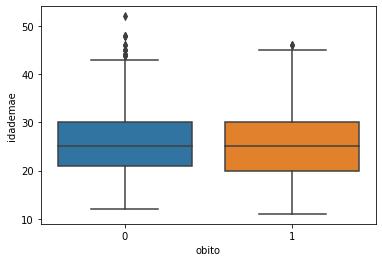

In [21]:
import seaborn as sns

sns.boxplot(data=dados, x='obito', y='idademae');

Para esta variável, a distribuição da `idademae` é bem parecida para as duas classes, apesar da classe 0 possuir mais *outliers*.

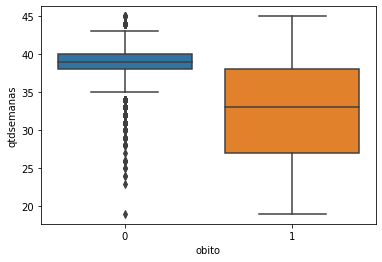

In [22]:
sns.boxplot(data=dados, x='obito', y='qtdsemanas');

Já para a variável `qtdsemanas`, temos uma discriminação muito maior. Veja que o 3º quartil da classe 1 é praticamente o 1º quartil da classe 0. As medianas estão muito longes. Esse pode ser um indício de que essa variável pode ser boa para o modelo.    

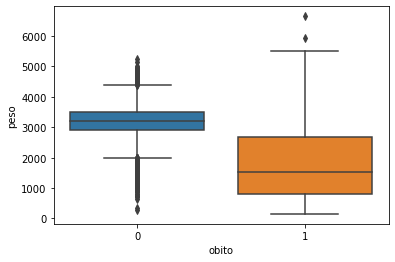

In [23]:
sns.boxplot(data=dados, x='obito', y='peso');

O peso também parece discriminar de forma clara as duas classes. Novamente, várias crianças que sobreviveram são *outliers* quanto ao `peso`.

Podemos fazer um teste: rodar modelos com os *outliers* e modelos sem os *outliers* posteriormente.    
Obs.: eu fiz isso porém não obtive melhoras,então não prossegui com essa abordagem.

In [24]:
# temos pouquíssima observações de "viúvas", então vou eliminar essa feature
# separando X e y
X = dados.drop(['id', 'estadocivilmae', 'catprenatal', 'tipoparto', 'sexo', 'malformacao', 'obito', 'estadocivil_viuva'], axis=1)
y = dados['obito']

X.head()

,idademae,qtdsemanas,peso,apgar1,apgar5,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,binario_sexo,binario_tipoparto,binario_malformacao,ord_catprenatal
0,13.0,36.0,2440.0,9.0,10.0,0,0,1,0,0.0,0.0,0.0,2.0
1,25.0,39.0,2850.0,9.0,10.0,1,0,0,0,0.0,1.0,0.0,3.0
2,27.0,38.0,3350.0,9.0,10.0,0,0,1,0,0.0,1.0,0.0,3.0
3,28.0,41.0,3065.0,8.0,9.0,0,0,1,0,1.0,0.0,0.0,3.0
4,21.0,39.0,3085.0,8.0,9.0,0,0,1,0,0.0,1.0,0.0,2.0


## Treinamento

## Qual validação escolher?    
       
Eu acho que podem acontecer duas coisas aqui:
      
- Os dados que estão na *leaderboard* foram *splitados* de forma que a porcentagem das classes da resposta `óbito` seja respeitada. Isso significa que 
se nos dados completos temos 80% de crianças sobreviventes e 20% de óbitos, então na *leaderboard* essa proporção é mantida. Isso se faz usando *estratificação*.    
    
- Os dados que estão na *leaderboard* foram *splitados* de forma aleatória. Neste caso, a porcentagem das classes da resposta `óbito` não é mantida, logo nos dados
completos podemos ter uma proporção 80/20, porém na leaderboard essa proporção ser de 95/5, por exemplo.
      
Pode ser que existam outras formas de tentar simular esse *split*, porém eu vou tentar esses dois.
    
Link legal para entender melhor os *splits* do *sklearn*:    
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

In [25]:
# relembrando quantidade de NaN para cada coluna
X.isnull().sum()

idademae                  0
qtdsemanas              226
peso                      2
apgar1                  100
apgar5                   95
estadocivil_casada        0
estadocivil_separada      0
estadocivil_solteira      0
estadocivil_uniao         0
binario_sexo             39
binario_tipoparto         5
binario_malformacao     304
ord_catprenatal          40
dtype: int64

## Validação com StratifiedKFold

In [26]:
from sklearn.model_selection import StratifiedKFold

for tr, val in StratifiedKFold(n_splits=5, shuffle=True, random_state=0).split(X, y):
    
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    print('Índices treino:', tr, '-> Índices validação:', val)
    print('Porcentagem obito = 1 (treino):', len(y_train[y_train == 1]) / len(y_train), 'Porcentagem obito = 0 (treino):', len(y_train[y_train == 0]) / len(y_train))
    print('Porcentagem obito = 1 (val):', len(y_val[y_val == 1]) / len(y_val), 'Porcentagem obito = 0 (val):', len(y_val[y_val == 0]) / len(y_val))
    print()
    
    # esta linha verifica se exista alguma intersecção entre os valores de treino e teste
    assert len(list(set(tr) & set(val))) == 0

Índices treino: [    2     3     5 ... 11386 11387 11388] -> Índices validação: [    0     1     4 ... 11356 11368 11375]
Porcentagem obito = 1 (treino): 0.26045439578531443 Porcentagem obito = 0 (treino): 0.7395456042146855
Porcentagem obito = 1 (val): 0.2603160667251975 Porcentagem obito = 0 (val): 0.7396839332748024

Índices treino: [    0     1     2 ... 11384 11385 11386] -> Índices validação: [    7     9    12 ... 11383 11387 11388]
Porcentagem obito = 1 (treino): 0.26045439578531443 Porcentagem obito = 0 (treino): 0.7395456042146855
Porcentagem obito = 1 (val): 0.2603160667251975 Porcentagem obito = 0 (val): 0.7396839332748024

Índices treino: [    0     1     2 ... 11385 11387 11388] -> Índices validação: [    8    10    14 ... 11381 11382 11386]
Porcentagem obito = 1 (treino): 0.26045439578531443 Porcentagem obito = 0 (treino): 0.7395456042146855
Porcentagem obito = 1 (val): 0.2603160667251975 Porcentagem obito = 0 (val): 0.7396839332748024

Índices treino: [    0     1     3

Como é possível notar, a porcentagem de `obito=1` para cada *fold* de treino e validação são aproximadamente iguais.    
Isso se deve à estratificação, que foi usada aqui.

## Validação com KFold

In [27]:
from sklearn.model_selection import KFold

for tr, val in KFold(n_splits=5, shuffle=True, random_state=0).split(X, y):
    
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    print('Índices treino:', tr, '-> Índices validação:', val)
    print('Porcentagem obito = 1 (treino):', len(y_train[y_train == 1]) / len(y_train), 'Porcentagem obito = 0 (treino):', len(y_train[y_train == 0]) / len(y_train))
    print('Porcentagem obito = 1 (val):', len(y_val[y_val == 1]) / len(y_val), 'Porcentagem obito = 0 (val):', len(y_val[y_val == 0]) / len(y_val))
    print()
    
    # esta linha verifica se exista alguma intersecção entre os valores de treino e teste
    assert len(list(set(tr) & set(val))) == 0

Índices treino: [    0     1     2 ... 11385 11386 11387] -> Índices validação: [    9    14    16 ... 11380 11384 11388]
Porcentagem obito = 1 (treino): 0.26155197014597736 Porcentagem obito = 0 (treino): 0.7384480298540226
Porcentagem obito = 1 (val): 0.2559262510974539 Porcentagem obito = 0 (val): 0.7440737489025461

Índices treino: [    0     1     2 ... 11386 11387 11388] -> Índices validação: [    5    15    20 ... 11373 11382 11383]
Porcentagem obito = 1 (treino): 0.2593568214246515 Porcentagem obito = 0 (treino): 0.7406431785753484
Porcentagem obito = 1 (val): 0.2647058823529412 Porcentagem obito = 0 (val): 0.7352941176470589

Índices treino: [    0     2     3 ... 11386 11387 11388] -> Índices validação: [    1     4     6 ... 11376 11378 11385]
Porcentagem obito = 1 (treino): 0.2610031829656459 Porcentagem obito = 0 (treino): 0.738996817034354
Porcentagem obito = 1 (val): 0.2581211589113257 Porcentagem obito = 0 (val): 0.7418788410886743

Índices treino: [    0     1     4 ..

Neste caso, a proporção ainda se manteve muito perto (eu pensei que as proporções iam ser bem distantes rsrs).      
Dá para notar que os índices mudaram: isso deve ser porque agora ele não está preocupado em manter a proporção exata, e talvez pegue outras observações da amostra que não sejam da mesma classe.

In [28]:
# proporção das classes na target
y.value_counts() / len(y)

0    0.739573
1    0.260427
Name: obito, dtype: float64

## Baseline usando KFold

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, brier_score_loss, log_loss, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMClassifier


auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []


kf = KFold(n_splits=5, shuffle=True, random_state=0)

for tr, val in kf.split(X, y):
    
    # splita em treino/validação
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]    
    
    
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())  
    
    
    # treina nos folds de treino
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    
    # calcula probabilidades para treino e validação
    # pega segunda coluna: P(Y = 1)
    prob_tr = clf.predict_proba(X_train)[:, 1]
    prob_val = clf.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.9562011034363005  AUC (val): 0.9474921193906
Acurácia (treino): 0.9373285040061464  Acurácia (val): 0.9253731343283582
Log loss (treino): 0.18817252061000997 Log loss (val): 0.22240708079610544

AUC (treino): 0.9555670920566799  AUC (val): 0.949397292146234
Acurácia (treino): 0.9353528701569531  Acurácia (val): 0.9284460052677788
Log loss (treino): 0.19280526812876062 Log loss (val): 0.20555863549472747

AUC (treino): 0.9557206156189149  AUC (val): 0.9446041138348831
Acurácia (treino): 0.9348040829766217  Acurácia (val): 0.9319578577699736
Log loss (treino): 0.19090209336526723 Log loss (val): 0.21366873754177457

AUC (treino): 0.9546768726612824  AUC (val): 0.9479265402843601
Acurácia (treino): 0.9342552957962902  Acurácia (val): 0.9328358208955224
Log loss (treino): 0.1953362246131084 Log loss (val): 0.19633490713096285

AUC (treino): 0.9557245826801348  AUC (val): 0.9498294243070363
Acurácia (treino): 0.9343722563652327  Acurácia (val): 0.9341238471673254
Log loss (t

## Baseline usando StratifiedKFold

In [30]:
auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for tr, val in skf.split(X, y):
    
    # splita em treino/validação
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]    
    
    
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean()) 
    
    
    # treina nos folds de treino
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    
    # calcula probabilidades para treino e validação
    # pega segunda coluna: P(Y = 1)
    prob_tr = clf.predict_proba(X_train)[:, 1]
    prob_val = clf.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.954537179111447  AUC (val): 0.9520794031254848
Acurácia (treino): 0.9339260234880913  Acurácia (val): 0.935908691834943
Log loss (treino): 0.1947944399389362 Log loss (val): 0.19583072336251867

AUC (treino): 0.9560083528495416  AUC (val): 0.9513553274853509
Acurácia (treino): 0.9350235978487542  Acurácia (val): 0.9284460052677788
Log loss (treino): 0.1920983792725421 Log loss (val): 0.20464274724906842

AUC (treino): 0.954740815624274  AUC (val): 0.9512252240531223
Acurácia (treino): 0.9346943255405554  Acurácia (val): 0.9266900790166813
Log loss (treino): 0.1916633676918763 Log loss (val): 0.21020966420032583

AUC (treino): 0.9572163005254706  AUC (val): 0.9412763821908714
Acurácia (treino): 0.9348040829766217  Acurácia (val): 0.9319578577699736
Log loss (treino): 0.19052899281853114 Log loss (val): 0.21159662981517613

AUC (treino): 0.9564122132010544  AUC (val): 0.9455098676963626
Acurácia (treino): 0.934811237928007  Acurácia (val): 0.930171277997365
Log loss (trei

Esse será nosso baseline, que por enquanto não possui nenhum tunning de hiperparâmetros. 

## Gerando submissão
    
Para gerar a submissão, precisamos fazer as mesmas transformações nos dados de teste.   

In [31]:
teste.isnull().sum()

id                  0
idademae            1
estadocivilmae     38
catprenatal        13
qtdsemanas         96
tipoparto           0
peso                0
malformacao       143
sexo               12
apgar1             48
apgar5             49
dtype: int64

In [32]:
# transformando categóricas nos dados de tete  
teste = teste.assign(**pd.get_dummies(teste['estadocivilmae'], prefix='estadocivil'))
teste['binario_sexo'] = teste['sexo'].map({'f': 0, 'm': 1}, na_action='ignore')
teste['binario_tipoparto'] = teste['tipoparto'].map({'vaginal': 0, 'cesareo': 1}, na_action='ignore')
teste['binario_malformacao'] = teste['malformacao'].map({'nao': 0, 'sim': 1}, na_action='ignore')
teste['ord_catprenatal'] = teste['catprenatal'].map({'nenhuma': 0, 'de1a3': 1, 'de4a6': 2, '7mais': 3}, na_action='ignore')

teste.head()

,id,idademae,estadocivilmae,catprenatal,qtdsemanas,tipoparto,peso,malformacao,sexo,apgar1,apgar5,estadocivil_casada,estadocivil_separada,estadocivil_solteira,estadocivil_uniao,estadocivil_viuva,binario_sexo,binario_tipoparto,binario_malformacao,ord_catprenatal
0,5493,24.0,casada,7mais,40.0,cesareo,3120.0,nao,f,9.0,10.0,1,0,0,0,0,0.0,1,0.0,3.0
1,12311,25.0,uniao,7mais,38.0,cesareo,2805.0,nao,f,9.0,10.0,0,0,0,1,0,0.0,1,0.0,3.0
2,15520,16.0,solteira,de4a6,39.0,cesareo,3600.0,nao,f,9.0,10.0,0,0,1,0,0,0.0,1,0.0,2.0
3,15095,22.0,uniao,de1a3,26.0,vaginal,635.0,nao,f,7.0,8.0,0,0,0,1,0,0.0,0,0.0,1.0
4,2275,29.0,casada,de1a3,26.0,cesareo,442.0,nao,m,3.0,8.0,1,0,0,0,0,1.0,1,0.0,1.0


In [33]:
teste.isnull().sum()

id                        0
idademae                  1
estadocivilmae           38
catprenatal              13
qtdsemanas               96
tipoparto                 0
peso                      0
malformacao             143
sexo                     12
apgar1                   48
apgar5                   49
estadocivil_casada        0
estadocivil_separada      0
estadocivil_solteira      0
estadocivil_uniao         0
estadocivil_viuva         0
binario_sexo             12
binario_tipoparto         0
binario_malformacao     143
ord_catprenatal          13
dtype: int64

## 1ª Submissão

In [34]:
def gera_submissao():
    
    # guarda ids
    sub = teste.copy()
    ids = sub['id']
    
    # dropa colunas não utilizadas pelo modelo
    sub = sub.drop(['id', 'estadocivilmae', 'catprenatal', 'tipoparto', 'sexo', 'malformacao', 'estadocivil_viuva'], axis=1)

    # imputando NaN
    # for col in ['idademae', 'qtdsemanas', 'apgar1', 'apgar5']:
    #    sub[col] = sub[col].fillna(sub[col].mean())
    
    
    # treina nos dados completos
    X_train = X.copy()
    y_train = y.copy()
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    print('Modelo treinado')
    
    # gera probabilidades
    print('Gerando probabilidades...')
    probs = clf.predict_proba(sub)
    print(probs)
    
    # gerando submissão
    print('Gerando submissão...')
    print('OK')
    
    return pd.DataFrame({'id': ids, 'obito': probs[:, 1]})  
    
    
sub1 = gera_submissao()

Modelo treinado
Gerando probabilidades...
[[0.9809207  0.01907935]
 [0.9678376  0.03216244]
 [0.9703326  0.02966739]
 ...
 [0.97209775 0.02790222]
 [0.9748806  0.0251194 ]
 [0.8786505  0.12134954]]
Gerando submissão...
OK


In [35]:
sub1.to_csv('sub1_xgboost_sem_tunning_missing_np.nan_sem_imputer.csv', index=False)

## Resultado
      
- Baseline notebook (KFold): 0.9478498979926228  
     
- Baseline notebook (StratifiedKFold): 0.9482892409102384
           
- Baseline public leaderboard: 0.94295
      
Fiquei contente com esse resultado, pois parece que de fato não houve nenhum vazamento de dados de validação para dados de treino, pois o AUC local ficou próximo do AUC da *leaderboard*.     
       
Parece que o cenário usando validação KFold ficou mais próximo do AUC da *public leaderboard*.      
Pode ser que eu esteja errado, porém pode ser que os dados da *leaderboard* não foram *splitados* por estratificação.

****

## Feature Engineering
      
Podemos criar duas *features* relacionadas a quantidade de semanas de gestação:
    
- prematuro: o bebê nasceu antes de 37 semanas
   
- pós-termo: o bebê nasceu depois de 42 semanas
    
Eu peguei essa referência de alguns sites de notícias, pois não consegui achar em fontes oficiais como SIM, por exemplo.
     
Outra ideia que eu tive também foi tentar usar as probabilidades condicionais (conjuntas) de `apgar1` e `apgar5` como *feature*.

In [36]:
X['qtdsemanas'].value_counts(dropna=False).sort_index()

19.0      15
20.0      28
21.0      39
22.0      70
23.0     117
24.0     129
25.0     113
26.0     135
27.0     126
28.0     167
29.0     119
30.0     134
31.0     140
32.0     156
33.0     156
34.0     215
35.0     319
36.0     516
37.0     907
38.0    2218
39.0    2849
40.0    1570
41.0     653
42.0     176
43.0      56
44.0      31
45.0       9
NaN      226
Name: qtdsemanas, dtype: int64

Há vários casos de bebês prematuros, assim também como casos de pós-termo. Talvez essas duas features possam ajudar o modelo.

In [37]:
# qual a probabilidade de escolher um obito=1 na amostra?
prob_obito = len(y[y == 1]) / len(y)
prob_obito

0.2604267275441215

E as probabilidades condicionais?      
    
$P(Y = 1 | \ apgar1 = 0, apgar5 = 0)$   
$P(Y = 1 | \ apgar1 = 1, apgar5 = 0)$   
             $\vdots$  
$P(Y = 1 | \ apgar1 = 10, apgar5 = 10)$

In [38]:
from itertools import permutations


# função para calcular probabilidades condicionais
def gera_probabilidades(dataset):
    
    # criando permutações:
    # [0, 0]
    # [0, 1]
    # ...
    # [0, 10]
    # [1, 0]
    # [1, 1]
    # ....
    # [1, 10]
    # ...

    primeira_combinacao = [(0, 0)]
    ultima_combinacao = [(10, 10)]
    permutacoes = list(permutations(range(0, 11), 2))
    permutacoes = primeira_combinacao + permutacoes + ultima_combinacao
    
    
    # cria mapa da probabilidades
    # vamos nos basear nos dados completos, porque em dados de teste não temos a informação de obito
    # ou seja, não é possível calcular a probabilidade lá
    mapa_probs_obito = dict()
    for a1, a5 in permutacoes:
        prob_numerador = ((dados['obito'] == 1) & (dados['apgar1'] == a1) & (dados['apgar5'] == a5)).sum()
        prob_denominador = ((dados['apgar1'] == a1) & (dados['apgar5'] == a5)).sum()
        prob = prob_numerador / prob_denominador

        mapa_probs_obito[str(a1)+str(a5)] = prob        
        
    # mapeia com o dataset  
    probs_features = np.zeros((len(dataset), 1))
    for i, (a1, a5) in enumerate(dataset[['apgar1', 'apgar5']].values):

        if pd.isna(a1) or pd.isna(a5):
            probs_features[i, 0] = 0.5
        else:
            probs_features[i, 0] = mapa_probs_obito.get(str(int(a1))+str(int(a5)), 0.5)
        
    for i in range(len(probs_features)):
        if pd.isna(probs_features[i, 0]):
            probs_features[i, 0] = np.nan            
            
    prob_obito = (dados['obito'] == 1).sum() / len(dados) 
            
    return probs_features / prob_obito

In [39]:
gera_probabilidades(X)

array([[0.19034706],
       [0.19034706],
       [0.19034706],
       ...,
       [0.19034706],
       [0.98337664],
       [0.49514907]])

In [40]:
X.isnull().sum()

idademae                  0
qtdsemanas              226
peso                      2
apgar1                  100
apgar5                   95
estadocivil_casada        0
estadocivil_separada      0
estadocivil_solteira      0
estadocivil_uniao         0
binario_sexo             39
binario_tipoparto         5
binario_malformacao     304
ord_catprenatal          40
dtype: int64

## Usando KFold

In [41]:
auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []

for tr, val in kf.split(X, y):
    
    # splita em treino/validação    
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)

    X_val['prematuro'] = np.where(X_val['qtdsemanas'] < 37, 1, 0)
    X_val['pos_termo'] = np.where(X_val['qtdsemanas'] > 42, 1, 0)
    X_val['probs'] = gera_probabilidades(X_val)
    
        
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
        

    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())
       
    # treina nos folds de treino
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    
    # calcula probabilidades para treino e validação
    # pega segunda coluna: P(Y = 1)
    prob_tr = clf.predict_proba(X_train)[:, 1]
    prob_val = clf.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.9558608015655882  AUC (val): 0.9470084042967664
Acurácia (treino): 0.937548018878279  Acurácia (val): 0.9258121158911325
Log loss (treino): 0.18768810525868443 Log loss (val): 0.22149037678760422

AUC (treino): 0.9565258877663725  AUC (val): 0.9498433207098834
Acurácia (treino): 0.9360114147733509  Acurácia (val): 0.9306409130816505
Log loss (treino): 0.19141783225059172 Log loss (val): 0.20493098588434633

AUC (treino): 0.9563553950222203  AUC (val): 0.9442458640260839
Acurácia (treino): 0.9352431127208869  Acurácia (val): 0.9315188762071993
Log loss (treino): 0.18948038072979903 Log loss (val): 0.2131385276422436

AUC (treino): 0.955308435755726  AUC (val): 0.9492439151739096
Acurácia (treino): 0.9346943255405554  Acurácia (val): 0.9341527655838455
Log loss (treino): 0.1945759788757308 Log loss (val): 0.1958220878554165

AUC (treino): 0.9554320851600324  AUC (val): 0.9496092626568157
Acurácia (treino): 0.9344820017559262  Acurácia (val): 0.9345630215195433
Log loss (t

Houve uma melhora pequena tanto no $AUC$ (0.9478498979926228 para 0.9479901533726919) quanto no $logloss$.    
Será mesmo que faz sentido aumentar a complexidade do modelo em troca desta melhora?         
Eu rodei alguns testes com alguns algoritmos (antes de usar a *feature* de probabilidades) de `feature selection` e não obtive melhoras.     
      
Apesar disso, foi possível perceber que as variáveis `peso`, `apgar_1` e `apgar_5` e `prematuro` (nesta ordem), se mostraram as 4 variáveis mais importantes para o `xgboost`. A variável `prematuro` é a nova variável criada aqui.    

In [42]:
print(0.9479901533726919 - 0.9478498979926228)

0.00014025538006912086


## Usando StratifiedKFold

In [43]:
auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []

for tr, val in skf.split(X, y):
    
    # splita em treino/validação    
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)

    X_val['prematuro'] = np.where(X_val['qtdsemanas'] < 37, 1, 0)
    X_val['pos_termo'] = np.where(X_val['qtdsemanas'] > 42, 1, 0)
    X_val['probs'] = gera_probabilidades(X_val)
    
    
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())

    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())

    
    # treina nos folds de treino
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    
    # calcula probabilidades para treino e validação
    # pega segunda coluna: P(Y = 1)
    prob_tr = clf.predict_proba(X_train)[:, 1]
    prob_val = clf.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.9543179383879468  AUC (val): 0.9517016027742056
Acurácia (treino): 0.9343650532323565  Acurácia (val): 0.9367866549604916
Log loss (treino): 0.19426944707720945 Log loss (val): 0.19473290143831098

AUC (treino): 0.9556609949895161  AUC (val): 0.9521934938275929
Acurácia (treino): 0.9359016573372846  Acurácia (val): 0.9293239683933274
Log loss (treino): 0.19189522140912674 Log loss (val): 0.20397122604675605

AUC (treino): 0.9543528055119951  AUC (val): 0.950356533444088
Acurácia (treino): 0.935682142465152  Acurácia (val): 0.9258121158911325
Log loss (treino): 0.19103146104661045 Log loss (val): 0.21003456616177202

AUC (treino): 0.9572353810231501  AUC (val): 0.9413713540791925
Acurácia (treino): 0.9351333552848206  Acurácia (val): 0.9341527655838455
Log loss (treino): 0.19004042588750275 Log loss (val): 0.21102177513538398

AUC (treino): 0.956046115825343  AUC (val): 0.9459199368723789
Acurácia (treino): 0.9357989464442493  Acurácia (val): 0.9292929292929293
Log loss 

O AUC para validação mudou de 0.9482892409102384 para 0.9483085841994916

In [44]:
print(0.9483085841994916 - 0.9482892409102384)

1.9343289253237472e-05


Em ambos validações, o aumento foi bem baixo, porém vamos submeter.

## 2ª submissão

In [45]:
def gera_submissao():
    
    # guarda ids
    sub = teste.copy()
    ids = sub['id']
    
    # dropa colunas não utilizadas pelo modelo
    sub = sub.drop(['id', 'estadocivilmae', 'catprenatal', 'tipoparto', 'sexo', 'malformacao', 'estadocivil_viuva'], axis=1)
    
    # cria novas features
    sub['prematuro'] = np.where(sub['qtdsemanas'] < 37, 1, 0)
    sub['pos_termo'] = np.where(sub['qtdsemanas'] > 42, 1, 0)
    sub['probs'] = gera_probabilidades(sub)

    # imputando NaN
    # for col in ['idademae', 'qtdsemanas', 'apgar1', 'apgar5']:
    #    sub[col] = sub[col].fillna(sub[col].mean())
    
    
    # treina nos dados completos
    X_train = X.copy()
    y_train = y.copy()    
    
    # cria novas features
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)    
    
    # imputa NaN
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    print('Modelo treinado')
    
    # gera probabilidades
    print('Gerando probabilidades...')
    probs = clf.predict_proba(sub)
    print(probs)
    
    # gerando submissão
    print('Gerando submissão...')
    print('OK')
    
    return pd.DataFrame({'id': ids, 'obito': probs[:, 1]})  
    
    
sub2 = gera_submissao()

Modelo treinado
Gerando probabilidades...
[[0.98075396 0.01924604]
 [0.9664296  0.03357042]
 [0.97055626 0.02944372]
 ...
 [0.9722435  0.02775653]
 [0.9737474  0.02625265]
 [0.8861414  0.11385855]]
Gerando submissão...
OK


In [46]:
sub2.to_csv('sub2_xgboost_semtunning_prematuro_pos_termo_probscondicionais_missingnp.nan_sem_imputer.csv', index=False)

## Resultado:
  
- AUC (validação KFold): 0.9480558292143977  
- AUC (validação StratifieldKFold): 0.9482892409102384
            
- AUC *leaderboard*: 0.94335
     
Melhorou um pouco o AUC, tanto localmente quanto na *leaderboard*.    
O AUC da *leaderboard* ainda está mais perto da validação KFold.    
Pode ser que a melhora tenha sido por acaso, porém podemos pensar que foi por causa das novas *features* também.

Eu parei por aqui. As próximas células foram experimentações que não melhoraram o modelo.

## Calibração do modelo
       
Vou fazer uma função que retorna um objeto do modelo XGBoost, porém calibrado. A ideia é reduzir o *brier score*:     https://en.wikipedia.org/wiki/Brier_score       
       
Esse tipo de método ajusta um modelo de regressão com as probabilidades preditas pelo classificador e tenta "calibrar" as probabilidades,
diminuindo os momentos que fazemos predições subestimados ou superestimadas. O método usa validação cruzada. Quando a resposta é binária 
ele utiliza KFold ou StratifiedKfold.   
          
Este vídeo explica bem o que é calibração de um modelo. É um pouco confuso, mas esse vídeo realmente explica bem o que é isso:         
https://www.youtube.com/watch?v=RXMu96RJj_s&list=PLYx7XA2nY5GcDQblpQ_M1V3PQPoLWiDAC&index=12 

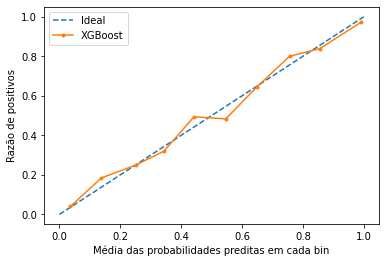

In [47]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss


def calibracao():

    # separa em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.67, random_state=0)

    # cria novas features
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)      
    
    # imputa NaN
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    # cria novas features
    X_val['prematuro'] = np.where(X_val['qtdsemanas'] < 37, 1, 0)
    X_val['pos_termo'] = np.where(X_val['qtdsemanas'] > 42, 1, 0)
    X_val['probs'] = gera_probabilidades(X_val)      
    
    # imputa NaN
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())
    

    # treina modelo
    clf = xgb.XGBClassifier(random_state=1, missing=np.nan)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_val)[:, 1]

    
    # treina calibrador com método isotônico (para amostras pequenas ele não é adequado)
    # aqui o argumento cv vai fazer o mesmo que fiz até agora (usar KFold ou StratifiedKFold)
    clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_val)[:, 1]
    
    # cria curva de calibração
    x_, y_ = calibration_curve(y_val, prob_pos_isotonic, n_bins=10, normalize=True) 
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal') 
    plt.plot(y_, x_, marker='.', label='XGBoost') 
    plt.legend(loc = 'upper left') 
    plt.xlabel('Média das probabilidades preditas em cada bin') 
    plt.ylabel('Razão de positivos') 
    plt.show(); 
    
    return clf_isotonic

clf_isotonic = calibracao()

## Usando KFold, com modelo calibrado

In [48]:
auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []

for tr, val in kf.split(X, y):
    
    # splita em treino/validação    
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    # cria novas features
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)

    # cria novas features
    X_val['prematuro'] = np.where(X_val['qtdsemanas'] < 37, 1, 0)
    X_val['pos_termo'] = np.where(X_val['qtdsemanas'] > 42, 1, 0)
    X_val['probs'] = gera_probabilidades(X_val)

    
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
        
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())

    
    # calcula probabilidades usando o modelo calibrado
    prob_tr = clf_isotonic.predict_proba(X_train)[:, 1]
    prob_val = clf_isotonic.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.9516259269109422  AUC (val): 0.9417609050936819
Acurácia (treino): 0.9342552957962902  Acurácia (val): 0.9244951712028094
Log loss (treino): 0.21355890134075978 Log loss (val): 0.3323735535916042

AUC (treino): 0.9504811193410766  AUC (val): 0.9465513229870548
Acurácia (treino): 0.9343650532323565  Acurácia (val): 0.9240561896400351
Log loss (treino): 0.24125205523956683 Log loss (val): 0.22161309478035252

AUC (treino): 0.9520996842560343  AUC (val): 0.9397918930885962
Acurácia (treino): 0.9327186916913621  Acurácia (val): 0.9306409130816505
Log loss (treino): 0.2282550098553845 Log loss (val): 0.27359557085378805

AUC (treino): 0.9480442572220598  AUC (val): 0.956214354566632
Acurácia (treino): 0.9298649983536385  Acurácia (val): 0.9420544337137841
Log loss (treino): 0.2494388626100224 Log loss (val): 0.18886945915602396

AUC (treino): 0.9461032572664256  AUC (val): 0.9637164674964052
Acurácia (treino): 0.9303116769095698  Acurácia (val): 0.940272288098375
Log loss (t

O AUC para validação mudou de 0.9479901533726919 para 0.949606988646474.   
Apesar disso, parece que a variância entre os *folds* mudou. Não sei se este modelo ficará melhor que o atual.

In [49]:
print(0.949606988646474 - 0.9479901533726919)

0.0016168352737820912


## Usando StratifiedKFold, com modelo calibrado

In [50]:
auc_treino = []
auc_validacao = []
acc_treino = []
acc_validacao = []
logloss_treino = []
logloss_validacao = []

for tr, val in skf.split(X, y):
    
    # splita em treino/validação    
    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y.iloc[tr], y.iloc[val]
    
    # cria novas features
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)

    # cria novas features
    X_val['prematuro'] = np.where(X_val['qtdsemanas'] < 37, 1, 0)
    X_val['pos_termo'] = np.where(X_val['qtdsemanas'] > 42, 1, 0)
    X_val['probs'] = gera_probabilidades(X_val)
    
    
    # imputando NaN para dados de treino e validação usando a média
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())

    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_val[col] = X_val[col].fillna(X_val[col].mean())

    
    # calcula probabilidades com o modelo calibrado
    prob_tr = clf_isotonic.predict_proba(X_train)[:, 1]
    prob_val = clf_isotonic.predict_proba(X_val)[:, 1]
    
    # calcula AUC
    auc_tr = roc_auc_score(y_train, prob_tr)
    auc_val = roc_auc_score(y_val, prob_val)
    
    # calcula acurácia
    acc_tr = accuracy_score(y_train, (prob_tr > .5).astype(int))
    acc_val = accuracy_score(y_val, (prob_val > .5).astype(int))
    
    # calcula log-loss
    logloss_tr = log_loss(y_train, prob_tr)
    logloss_val = log_loss(y_val, prob_val)
    
    # guarda resultados
    auc_treino.append(auc_tr)
    auc_validacao.append(auc_val)
    acc_treino.append(acc_tr)
    acc_validacao.append(acc_val)
    logloss_treino.append(logloss_tr)
    logloss_validacao.append(logloss_val)
    
    print('AUC (treino):', auc_tr, ' AUC (val):', auc_val)
    print('Acurácia (treino):', acc_tr, ' Acurácia (val):', acc_val)
    print('Log loss (treino):', logloss_tr, 'Log loss (val):', logloss_val)
    print()
    
print('Média AUC (treino):', np.mean(auc_treino))
print('Média AUC (val):', np.mean(auc_validacao))
print('Média Acurácia (treino):', np.mean(acc_treino))
print('Média Acurácia (val):', np.mean(acc_validacao))
print('Média Log-loss (treino):', np.mean(logloss_treino))
print('Média Log-loss (val):', np.mean(logloss_validacao))

AUC (treino): 0.9486209942990533  AUC (val): 0.9538548145775891
Acurácia (treino): 0.9316211173306992  Acurácia (val): 0.9350307287093942
Log loss (treino): 0.24605031382540746 Log loss (val): 0.20242216678404285

AUC (treino): 0.9493569564196598  AUC (val): 0.9507998859092979
Acurácia (treino): 0.9329382065634947  Acurácia (val): 0.9297629499561019
Log loss (treino): 0.2333625061452578 Log loss (val): 0.25316782779099783

AUC (treino): 0.9484434377695947  AUC (val): 0.9545463643596658
Acurácia (treino): 0.933047963999561  Acurácia (val): 0.9293239683933274
Log loss (treino): 0.22579398749640386 Log loss (val): 0.2834385799462692

AUC (treino): 0.9516292805688967  AUC (val): 0.9415513008149587
Acurácia (treino): 0.9314016024585665  Acurácia (val): 0.935908691834943
Log loss (treino): 0.23914131627002017 Log loss (val): 0.2300551240830478

AUC (treino): 0.9503022421642999  AUC (val): 0.9472628007674653
Acurácia (treino): 0.9325065847234416  Acurácia (val): 0.9314888010540184
Log loss (t

O AUC para validação mudou de 0.9482892409102384 para 0.9496030332857954

In [51]:
print(0.9496030332857954 - 0.9482892409102384)

0.0013137923755570657


## 3ª submissão

In [52]:
def gera_submissao():
    
    # guarda ids
    sub = teste.copy()
    ids = sub['id']
    
    # dropa colunas não utilizadas pelo modelo
    sub = sub.drop(['id', 'estadocivilmae', 'catprenatal', 'tipoparto', 'sexo', 'malformacao', 'estadocivil_viuva'], axis=1)
    
    # cria novas features
    sub['prematuro'] = np.where(sub['qtdsemanas'] < 37, 1, 0)
    sub['pos_termo'] = np.where(sub['qtdsemanas'] > 42, 1, 0)
    sub['probs'] = gera_probabilidades(sub) 

    # imputando NaN
    # for col in ['idademae', 'qtdsemanas', 'apgar1', 'apgar5']:
    #    sub[col] = sub[col].fillna(sub[col].mean())

    
    # treina nos dados completos
    # aqui precisamos imputar novamente, porque os dados originais não estão imputados
    X_train = X.copy()
    y_train = y.copy()    
    
    # cria novas features
    X_train['prematuro'] = np.where(X_train['qtdsemanas'] < 37, 1, 0)
    X_train['pos_termo'] = np.where(X_train['qtdsemanas'] > 42, 1, 0)
    X_train['probs'] = gera_probabilidades(X_train)    
    
    # imputa NaN
    # for col in ['qtdsemanas', 'peso', 'apgar1', 'apgar5']:
    #    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
    # gera probabilidades com o modelo calibrado
    print('Gerando probabilidades...')
    probs = clf_isotonic.predict_proba(sub)
    print(probs)
    
    # gerando submissão
    print('Gerando submissão...')
    print('OK')
    
    return pd.DataFrame({'id': ids, 'obito': probs[:, 1]})  
    
    
sub3 = gera_submissao()

Gerando probabilidades...
[[0.97966743 0.02033257]
 [0.96095505 0.03904495]
 [0.98668546 0.01331454]
 ...
 [0.96467363 0.03532637]
 [0.96777317 0.03222683]
 [0.92892046 0.07107954]]
Gerando submissão...
OK


In [53]:
sub3.to_csv('sub3_xgboost_calibradocom5folds_test_frac0.67_com_prematuro_pos_termo_probscondicionais_missingnp.nan_sem_imputer.csv', index=False)

## Resultado
       
- AUC (Kfold): 0.949606988646474       
- AUC (StratifiedKFold): 0.9496030332857954
    
- AUC (public *leaderboard*): 0.94115
     
O AUC caiu um pouco na *public leaderboard*.

## Alguns outros *insights*

In [54]:
apgar_obito = pd.DataFrame({'apgar1': X['apgar1'], 'apgar5': X['apgar5'], 'obito': y})
apgar_obito.head(10)

,apgar1,apgar5,obito
0,9.0,10.0,0
1,9.0,10.0,0
2,9.0,10.0,0
3,8.0,9.0,0
4,8.0,9.0,0
5,9.0,10.0,0
6,0.0,6.0,1
7,9.0,10.0,0
8,8.0,9.0,0
9,9.0,10.0,0


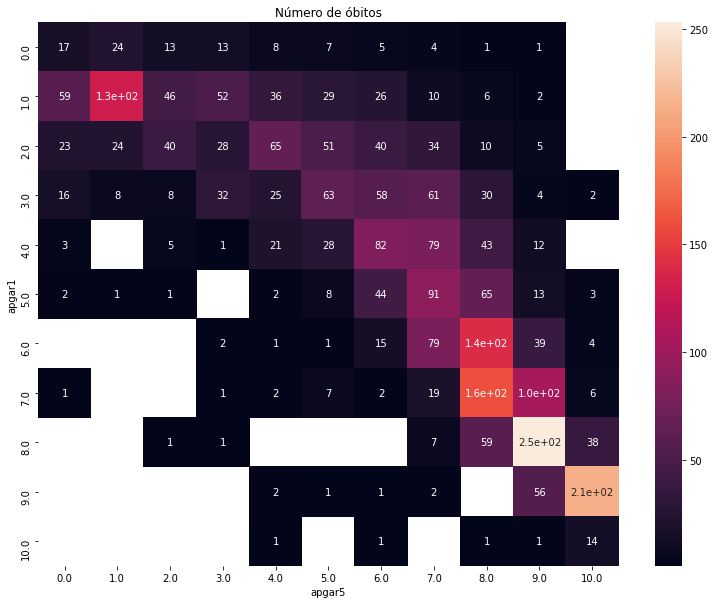

In [55]:
import seaborn as sns

fig, _ = plt.subplots(figsize=(13, 10))

piv = pd.pivot_table(apgar_obito[apgar_obito['obito'] == 1][['apgar1', 'apgar5']].groupby(['apgar1', 'apgar5']).size().reset_index(name='obitos'),
                     values='obitos', index=['apgar1'], columns=['apgar5'])
ax = sns.heatmap(piv, annot=True)
plt.title('Número de óbitos')
fig.show();

Intuitivamente eu pensei que teríamos mais óbitos quando as 2 variáveis são pequenas (entre 0 e 3), porém podemos ver que há muitos casos quando os valores são grandes (entre 6 e 10).

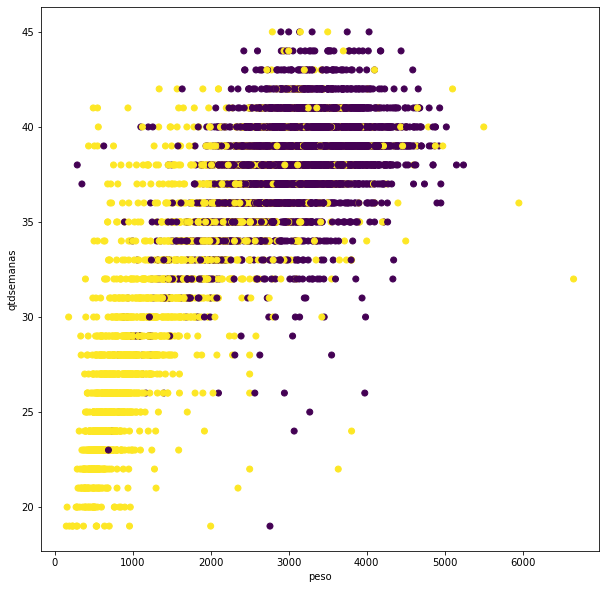

In [56]:
fig, _ = plt.subplots(figsize=(10, 10))

plt.scatter(X['peso'], X['qtdsemanas'], c=y)
plt.xlabel('peso')
plt.ylabel('qtdsemanas')

fig.show();

A relação entre `peso` e `qtdsemanas` também é interessante.

## Conclusão:  
     
- As submissões com o modelo calibrado também não melhoraram, apesar de localmente melhorarem muito. O curioso é que este
modelo calibrado foi o melhor modelo no *private leaderboard*. Talvez calibrar os modelos seja uma boa forma para que seu
modelo consiga generalizar para dados novos.   
        
No final das contas eu usei a submissão 2 como principal, e a submissão 1 como secundária. Ambas ficaram bem próximas no *private leaderboard*.